In [15]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import pickle

### FOLDER LABELS ###

sensornames = ['color', 'depthcolormap', 'icub_left', 'icub_right']
toolnames = ['hook', 'ruler', 'spatula', 'sshot']
actions = ['left_to_right', 'pull', 'push', 'right_to_left']
objectnames = ['0_woodenCube', '1_pearToy', '2_yogurtYellowbottle', '3_cowToy', '4_tennisBallYellowGreen',
               '5_blackCoinBag', '6_lemonSodaCan', '7_peperoneGreenToy', '8_boxEgg', '9_pumpkinToy',
               '10_tomatoCan', '11_boxMilk', '12_containerNuts', '13_cornCob', '14_yellowFruitToy',
               '15_bottleNailPolisher', '16_boxRealSense', '17_clampOrange', '18_greenRectangleToy', '19_ketchupToy']

### FUNCTIONS ###
def concatenate(image_1, image_2):
    # Concatenate the image
    return np.concatenate((image_1, image_2), axis=1)

def normalize(image):
    # Normalize the image
    return image/255

def resize(image, width, height):
    # Resize an image to a fixed size
    return cv2.resize(image, (width, height))

def bgr_to_rgb(image):
    # Changes the images from BGR to RGB
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def image_from_array(image):
    # Changes the array to image
    return Image.fromarray(image)

def flatten(image, width, height):
    # Flatten the images
    return image.flatten().reshape(1, width*height*3)

def to_float(image):
    # Convert to float32
    return image.astype(np.float32)



In [ ]:
width, height = 128,128

# Color images
#color_channels = 3
inp_size_color = width*height*3*2  # (64*64*3*2 = 24576)

# Training color images
training_color = np.zeros((1, inp_size_color), dtype=np.float32)
training_icub_left = np.zeros((1, inp_size_color), dtype=np.float32)
training_icub_right = np.zeros((1, inp_size_color), dtype=np.float32)

# Validation color images
validation_color = np.zeros((1, inp_size_color), dtype=np.float32)
validation_icub_left = np.zeros((1, inp_size_color), dtype=np.float32)
validation_icub_right = np.zeros((1, inp_size_color), dtype=np.float32)

# Test color images
testing_color = np.zeros((1, inp_size_color), dtype=np.float32)
testing_icub_left = np.zeros((1, inp_size_color), dtype=np.float32)
testing_icub_right = np.zeros((1, inp_size_color), dtype=np.float32)


# Checking shapes
print("Training shapes:", training_color.shape, training_icub_left.shape, training_icub_right.shape)
print("Validation shapes:", validation_color.shape, validation_icub_left.shape, validation_icub_right.shape)
print("Testing shapes:", testing_color.shape, testing_icub_left.shape, testing_icub_right.shape)

y_training, y_validation, y_testing = [], [], []


for a in range(len(objectnames)):
    objectname = objectnames[a]
    for y in range(len(toolnames)):
        toolname = toolnames[y]
        for x in range(len(actions)):
            action = actions[x]
            label = actions.index(action)
            
            # Split into sets: 60% Training, 20% Validation, 20% Testing
            ids = np.random.choice(np.arange(10), 10, replace=False)
            training_ids, validation_ids, testing_ids = ids[0:6], ids[6:8], ids[8:10]
            
            for i in range(len(sensornames)):
                sensor = sensornames[i]
                path = '/mnt/my_dataset/second_affordance_dataset/' + objectname + '/' + toolname + '/' + action + '/' + sensor + '/'

                # Loop through the number of repeats
                for j in range(10):
                    if sensor == 'icub_right' or sensor == 'icub_left':
                        init = cv2.imread(path + 'init_color_' + sensor + '_' + str(j) + '.png')
                        effect = cv2.imread(path + 'effect_color_' + sensor + '_' + str(j) + '.png')
                    else:
                        init = cv2.imread(path + 'init_' + sensor + '_' + str(j) + '.png')
                        effect = cv2.imread(path + 'effect_' + sensor + '_' + str(j) + '.png')

                    # Pre-processing steps
                    init = resize(init, width, height)
                    effect = resize(effect, width, height)
                    init = bgr_to_rgb(init)
                    effect = bgr_to_rgb(effect)
                    init = normalize(init)
                    effect = normalize(effect)
                    init = flatten(init, width, height)
                    effect = flatten(effect, width, height)
                    init = to_float(init)
                    effect = to_float(effect)
                    image = concatenate(init, effect)

                    if j in training_ids:
                        if sensor == 'color':
                            training_color = np.append(training_color, image, axis=0)
                            training_color = np.append(training_color, image, axis=0)
                        if sensor == 'depthcolormap':
                            training_depth = np.append(training_depth, image, axis=0)
                        if sensor == 'icub_left':
                            training_icub_left = np.append(training_icub_left, image, axis=0)
                        if sensor == 'icub_right':
                            training_icub_right = np.append(training_icub_right, image, axis=0)
                        y_training.append(label)

                    if j in validation_ids:
                        if sensor == 'color':
                            validation_color = np.append(validation_color, image, axis=0)
                        if sensor == 'depthcolormap':
                            validation_depth = np.append(validation_depth, image, axis=0)
                        if sensor == 'icub_left':
                            validation_icub_left = np.append(validation_icub_left, image, axis=0)
                        if sensor == 'icub_right':
                            validation_icub_right = np.append(validation_icub_right, image, axis=0)
                        y_validation.append(label)

                    if j in testing_ids:
                        if sensor == 'color':
                            testing_color = np.append(testing_color, image, axis=0)
                        if sensor == 'depthcolormap':
                            testing_depth = np.append(testing_depth, image, axis=0)
                        if sensor == 'icub_left':
                            testing_icub_left = np.append(testing_icub_left, image, axis=0)
                        if sensor == 'icub_right':
                            testing_icub_right = np.append(testing_icub_right, image, axis=0)
                        y_testing.append(label)
    print('concatenating of images' + ' ' + objectname + ' ' + 'done')

# Remove the first row  Because of we are appending to a empty array
training_color, training_icub_right, training_icub_left = training_color[1:], training_icub_right[1:], training_icub_left[1:]
training_depth = training_depth[1:]

validation_color, validation_icub_right, validation_icub_left = validation_color[1:], validation_icub_right[1:], validation_icub_left[1:]
validation_depth = validation_depth[1:]

testing_color, testing_icub_right, testing_icub_left = testing_color[1:], testing_icub_right[1:], testing_icub_left[1:]
testing_depth = testing_depth[1:]

# Checking shapes
print("training: ", training_color.shape, training_icub_right.shape, training_icub_left.shape, training_depth.shape)
print("validation: ", validation_color.shape, validation_icub_right.shape, validation_icub_left.shape, validation_depth.shape)
print("testing: ", testing_color.shape, testing_icub_right.shape, testing_icub_left.shape, testing_depth.shape)

y_training = np.asarray(y_training, dtype=np.int32)
y_validation = np.asarray(y_validation, dtype=np.int32)
y_testing = np.asarray(y_testing, dtype=np.int32)

# Checking shapes
print(y_training.shape, y_validation.shape, y_testing.shape)

# Takes every fourth item starting from 0th item. 
y_training = y_training[0::4]
y_validation = y_validation[0::4]
y_testing = y_testing[0::4]

# Checking shapes again
print(y_training.shape, y_validation.shape, y_testing.shape)

# Save io matrices
pickle.dump(training_color, open('E:/training_color.pkl', 'wb'))
pickle.dump(training_icub_right, open('E:/training_icub_right.pkl', 'wb'))
pickle.dump(training_icub_left, open('E:/training_icub_left.pkl', 'wb'))
pickle.dump(training_depth, open('E:/training_depth.pkl', 'wb'))

pickle.dump(validation_color, open('E:/validation_color.pkl', 'wb'))
pickle.dump(validation_icub_right, open('E:/validation_icub_right.pkl', 'wb'))
pickle.dump(validation_icub_left, open('E:/validation_icub_left.pkl', 'wb'))
pickle.dump(validation_depth, open('E:/validation_depth.pkl', 'wb'))

pickle.dump(testing_color, open('E:/testing_color.pkl', 'wb'))
pickle.dump(testing_icub_right, open('E:/testing_icub_right.pkl', 'wb'))
pickle.dump(testing_icub_left, open('E:/testing_icub_left.pkl', 'wb'))
pickle.dump(testing_depth, open('E:/testing_depth.pkl', 'wb'))

pickle.dump(y_training, open('E:/y_training.pkl', 'wb'))
pickle.dump(y_validation, open('E:/y_validation.pkl', 'wb'))
pickle.dump(y_testing, open('E:/y_testing.pkl', 'wb'))



/mnt/my_dataset/second_affordance_dataset/action_recognition_dataset/0_woodenCube/hook/right_to_left/color/init_color_9.png
/mnt/my_dataset/second_affordance_dataset/action_recognition_dataset/1_pearToy/hook/right_to_left/color/init_color_9.png
/mnt/my_dataset/second_affordance_dataset/action_recognition_dataset/2_yogurtYellowbottle/hook/right_to_left/color/init_color_9.png
/mnt/my_dataset/second_affordance_dataset/action_recognition_dataset/3_cowToy/hook/right_to_left/color/init_color_9.png
/mnt/my_dataset/second_affordance_dataset/action_recognition_dataset/4_tennisBallYellowGreen/hook/right_to_left/color/init_color_9.png
/mnt/my_dataset/second_affordance_dataset/action_recognition_dataset/5_blackCoinBag/hook/right_to_left/color/init_color_9.png
/mnt/my_dataset/second_affordance_dataset/action_recognition_dataset/6_lemonSodaCan/hook/right_to_left/color/init_color_9.png
/mnt/my_dataset/second_affordance_dataset/action_recognition_dataset/7_peperoneGreenToy/hook/right_to_left/color/ini

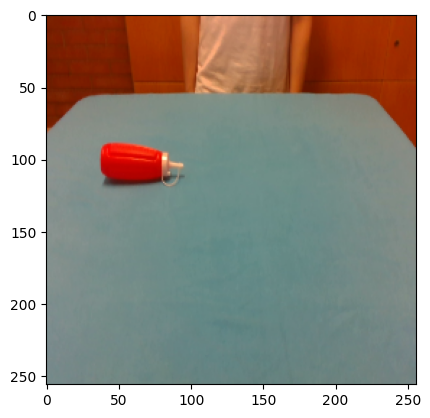

In [20]:
for obj in objectnames:
    path  = "/mnt/my_dataset/second_affordance_dataset/action_recognition_dataset/"+ obj +"/hook/right_to_left/color/init_color_9.png"
    print(path)
    init = cv2.imread(path)
    effect = cv2.imread(path)
    if init is None or effect is None:
        print(f"Failed to load image at {path}")
        continue
    width = 256
    height =256
    # Pre-processing steps
    init = resize(init, width, height)
    effect = resize(effect, width, height)
    init = bgr_to_rgb(init)
    effect = bgr_to_rgb(effect)
    plt.imshow(init)
    plt.savefig("./"+ obj +".png")
    
    